In [14]:
import scipy.io as sio
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from google.colab import files

try:
    data = sio.loadmat('ovariancancer.mat')
except FileNotFoundError:
    print("Please upload ovariancancer.mat")
    uploaded = files.upload()
    data = sio.loadmat('ovariancancer.mat')

def split_dataset(file_path, train_ratio=0.7, valid_ratio=0.15, test_ratio=0.15):
    if file_path.endswith('.mat'):
        data_dict = sio.loadmat(file_path)
        X = data_dict['obs']
        y = data_dict['grp']
        if y.dtype.type is np.str_ or y.dtype.type is np.object_:
            y = np.array([1 if 'Cancer' in str(label) or 'cancer' in str(label) else 0 for label in y]).reshape(-1, 1)

    np.random.seed(42)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    train_size = int(len(X) * train_ratio)
    valid_size = int(len(X) * valid_ratio)

    X_train = X[:train_size]
    y_train = y[:train_size]
    X_valid = X[train_size : train_size + valid_size]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size :]
    y_test = y[train_size + valid_size :]

    return X_train, X_valid, X_test, y_train, y_valid, y_test

X_train_raw, X_valid_raw, X_test_raw, y_train, y_valid, y_test = split_dataset('ovariancancer.mat', train_ratio=0.7)

train_mean = np.mean(X_train_raw, axis=0)
train_std = np.std(X_train_raw, axis=0)
epsilon = 1e-8

X_train = (X_train_raw - train_mean) / (train_std + epsilon)
X_valid = (X_valid_raw - train_mean) / (train_std + epsilon)
X_test = (X_test_raw - train_mean) / (train_std + epsilon)
print("Dataset loaded, split, and normalized.")

def ReLu(x): return np.maximum(0, x)
def ReLu_derivative(x): return (x > 0).astype(float)
def sigmoid(x): return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def loss_func(y_true, y_pred):
    m = y_true.shape[0]
    return - (1/m) * np.sum(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))

Dataset loaded, split, and normalized.


# Part_1



In [15]:
def param_init(nx, nh, ny):
    np.random.seed(123)
    return {
        "W1": np.random.randn(nx, nh) * np.sqrt(2/nx), "b1": np.zeros((1, nh)),
        "W2": np.random.randn(nh, ny) * 0.01,         "b2": np.zeros((1, ny))
    }

def fwd_prop(X, params):
    Z1 = np.dot(X, params["W1"]) + params["b1"]
    A1 = ReLu(Z1)
    Z2 = np.dot(A1, params["W2"]) + params["b2"]
    A2 = sigmoid(Z2)
    return {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}

def back_prop(X, y, params, res):
    m = X.shape[0]
    dZ2 = res["A2"] - y
    dW2 = np.dot(res["A1"].T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)
    dZ1 = np.dot(dZ2, params["W2"].T) * ReLu_derivative(res["Z1"])
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)
    return {"dW1": dW1, "dW2": dW2, "db1": db1, "db2": db2}

def sgd_optimizer(params, grads, lr):
    for k in params.keys(): params[k] -= lr * grads["d"+k]
    return params

def train_no_validation(X_train, y_train, hidden_nodes=100, epochs=500, lr=0.01):
    n_x = X_train.shape[1]
    n_y = 1
    params = param_init(n_x, hidden_nodes, n_y)
    loss_history = []

    print(f"--- Q1: Training Start (No Validation) | Hidden Nodes: {hidden_nodes} ---")
    for epoch in range(epochs):
        indices = np.random.permutation(X_train.shape[0])
        for i in indices:
            xi = X_train[i:i+1]
            yi = y_train[i:i+1]
            cache = fwd_prop(xi, params)
            grads = back_prop(xi, yi, params, cache)
            params = sgd_optimizer(params, grads, lr)

        A2_train = fwd_prop(X_train, params)["A2"]
        train_loss = loss_func(y_train, A2_train)
        loss_history.append(train_loss)

        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Train Loss {train_loss:.4f}")

    return params, loss_history

params_no_val, history_no_val = train_no_validation(X_train, y_train, hidden_nodes=100, epochs=500, lr=0.005)

--- Q1: Training Start (No Validation) | Hidden Nodes: 100 ---
Epoch 0: Train Loss 0.2051
Epoch 20: Train Loss 0.0014
Epoch 40: Train Loss 0.0006
Epoch 60: Train Loss 0.0004
Epoch 80: Train Loss 0.0003
Epoch 100: Train Loss 0.0002
Epoch 120: Train Loss 0.0002
Epoch 140: Train Loss 0.0001
Epoch 160: Train Loss 0.0001
Epoch 180: Train Loss 0.0001
Epoch 200: Train Loss 0.0001
Epoch 220: Train Loss 0.0001
Epoch 240: Train Loss 0.0001
Epoch 260: Train Loss 0.0001
Epoch 280: Train Loss 0.0001
Epoch 300: Train Loss 0.0001
Epoch 320: Train Loss 0.0001
Epoch 340: Train Loss 0.0000
Epoch 360: Train Loss 0.0000
Epoch 380: Train Loss 0.0000
Epoch 400: Train Loss 0.0000
Epoch 420: Train Loss 0.0000
Epoch 440: Train Loss 0.0000
Epoch 460: Train Loss 0.0000
Epoch 480: Train Loss 0.0000


# Part_2


--- Q2: Training Start (With Validation) | Hidden Nodes: 100 ---
Epoch 0: Train Loss 0.2051 | Val Loss 0.2798
Epoch 20: Train Loss 0.0014 | Val Loss 0.0407
Epoch 40: Train Loss 0.0006 | Val Loss 0.0347
Epoch 60: Train Loss 0.0004 | Val Loss 0.0319
Epoch 80: Train Loss 0.0003 | Val Loss 0.0301
Epoch 100: Train Loss 0.0002 | Val Loss 0.0289
Epoch 120: Train Loss 0.0002 | Val Loss 0.0280
Epoch 140: Train Loss 0.0001 | Val Loss 0.0272
Epoch 160: Train Loss 0.0001 | Val Loss 0.0266
Epoch 180: Train Loss 0.0001 | Val Loss 0.0260
Epoch 200: Train Loss 0.0001 | Val Loss 0.0256
Epoch 220: Train Loss 0.0001 | Val Loss 0.0251
Epoch 240: Train Loss 0.0001 | Val Loss 0.0248
Epoch 260: Train Loss 0.0001 | Val Loss 0.0244
Epoch 280: Train Loss 0.0001 | Val Loss 0.0241
Epoch 300: Train Loss 0.0001 | Val Loss 0.0238
Epoch 320: Train Loss 0.0001 | Val Loss 0.0236
Epoch 340: Train Loss 0.0000 | Val Loss 0.0233
Epoch 360: Train Loss 0.0000 | Val Loss 0.0231
Epoch 380: Train Loss 0.0000 | Val Loss 0.0229
E

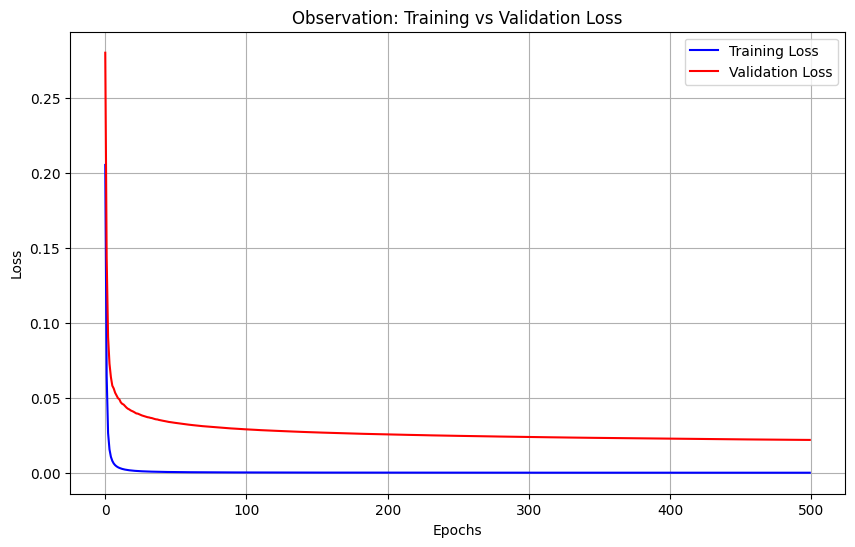

In [16]:
def train_with_validation(X_train, y_train, X_val, y_val, hidden_nodes=100, epochs=500, lr=0.01):
    n_x = X_train.shape[1]
    n_y = 1
    params = param_init(n_x, hidden_nodes, n_y)
    history = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')
    best_params = None

    print(f"--- Q2: Training Start (With Validation) | Hidden Nodes: {hidden_nodes} ---")
    for epoch in range(epochs):
        indices = np.random.permutation(X_train.shape[0])
        for i in indices:
            xi = X_train[i:i+1]
            yi = y_train[i:i+1]
            cache = fwd_prop(xi, params)
            grads = back_prop(xi, yi, params, cache)
            params = sgd_optimizer(params, grads, lr)

        res_train = fwd_prop(X_train, params)
        t_loss = loss_func(y_train, res_train["A2"])

        res_val = fwd_prop(X_val, params)
        v_loss = loss_func(y_val, res_val["A2"])

        history['train_loss'].append(t_loss)
        history['val_loss'].append(v_loss)

        if v_loss < best_val_loss:
            best_val_loss = v_loss
            best_params = {k: v.copy() for k, v in params.items()}

        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Train Loss {t_loss:.4f} | Val Loss {v_loss:.4f}")

    print(f"Best Validation Loss: {best_val_loss:.4f}")
    return best_params, history

params_val, history_val = train_with_validation(X_train, y_train, X_valid, y_valid, hidden_nodes=100, epochs=500, lr=0.005)

def plot_observations(history):
    epochs = range(len(history['train_loss']))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Observation: Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_observations(history_val)

# Part_3

In [17]:
def param_init_deep(n_x, h1, h2, n_y):
    np.random.seed(70)
    return {
        "W1": np.random.randn(n_x, h1) * np.sqrt(2/n_x), "b1": np.zeros((1, h1)),
        "W2": np.random.randn(h1, h2) * np.sqrt(2/h1), "b2": np.zeros((1, h2)),
        "W3": np.random.randn(h2, n_y) * 0.01,         "b3": np.zeros((1, n_y))
    }

def fwd_prop_deep(X, params):
    Z1 = np.dot(X, params["W1"]) + params["b1"]
    A1 = ReLu(Z1)
    Z2 = np.dot(A1, params["W2"]) + params["b2"]
    A2 = ReLu(Z2)
    Z3 = np.dot(A2, params["W3"]) + params["b3"]
    A3 = sigmoid(Z3)
    return {"Z1":Z1, "A1":A1, "Z2":Z2, "A2":A2, "Z3":Z3, "A3":A3}

def back_prop_deep(X, y, params, res):
    dZ3 = res["A3"] - y
    dW3 = np.dot(res["A2"].T, dZ3)
    db3 = np.sum(dZ3, axis=0, keepdims=True)

    dA2 = np.dot(dZ3, params["W3"].T)
    dZ2 = dA2 * ReLu_derivative(res["Z2"])
    dW2 = np.dot(res["A1"].T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dA1 = np.dot(dZ2, params["W2"].T)
    dZ1 = dA1 * ReLu_derivative(res["Z1"])
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    return {"dW1":dW1, "db1":db1, "dW2":dW2, "db2":db2, "dW3":dW3, "db3":db3}

def sgd_optimizer_deep(params, grads, lr):
    for i in range(1, 4):
        params[f"W{i}"] -= lr * grads[f"dW{i}"]
        params[f"b{i}"] -= lr * grads[f"db{i}"]
    return params

def train_deep_no_validation(X_train, y_train, h1=64, h2=32, epochs=500, lr=0.005):
    n_x, n_y = X_train.shape[1], 1
    params = param_init_deep(n_x, h1, h2, n_y)

    print(f"--- Q3 Part 1: Deep Training (No Validation) | Layers: {h1}->{h2} ---")
    for epoch in range(epochs):
        indices = np.random.permutation(X_train.shape[0])
        for i in indices:
            xi, yi = X_train[i:i+1], y_train[i:i+1]
            cache = fwd_prop_deep(xi, params)
            grads = back_prop_deep(xi, yi, params, cache)
            params = sgd_optimizer_deep(params, grads, lr)

        if epoch % 20 == 0:
            A3_train = fwd_prop_deep(X_train, params)["A3"]
            t_loss = loss_func(y_train, A3_train)
            print(f"Epoch {epoch}: Train Loss {t_loss:.4f}")

    return params

def train_deep_with_validation(X_train, y_train, X_val, y_val, h1=64, h2=32, epochs=500, lr=0.005):
    n_x, n_y = X_train.shape[1], 1
    params = param_init_deep(n_x, h1, h2, n_y)
    history = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')
    best_params = None

    print(f"--- Q3 Part 2: Deep Training (With Validation) | Layers: {h1}->{h2} ---")
    for epoch in range(epochs):
        indices = np.random.permutation(X_train.shape[0])
        for i in indices:
            xi, yi = X_train[i:i+1], y_train[i:i+1]
            cache = fwd_prop_deep(xi, params)
            grads = back_prop_deep(xi, yi, params, cache)
            params = sgd_optimizer_deep(params, grads, lr)

        A3_train = fwd_prop_deep(X_train, params)["A3"]
        A3_val = fwd_prop_deep(X_val, params)["A3"]

        t_loss = loss_func(y_train, A3_train)
        v_loss = loss_func(y_val, A3_val)
        history['train_loss'].append(t_loss)
        history['val_loss'].append(v_loss)

        if v_loss < best_val_loss:
            best_val_loss = v_loss
            best_params = {k: v.copy() for k, v in params.items()}

        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Train Loss {t_loss:.4f} | Val Loss {v_loss:.4f}")

    print(f"Best Validation Loss: {best_val_loss:.4f}")
    return best_params, history

params_deep_no_val = train_deep_no_validation(X_train, y_train, h1=64, h2=32, epochs=500, lr=0.005)
params_deep_val, history_deep = train_deep_with_validation(X_train, y_train, X_valid, y_valid, h1=64, h2=32, epochs=500, lr=0.005)

--- Q3 Part 1: Deep Training (No Validation) | Layers: 64->32 ---
Epoch 0: Train Loss 0.2838
Epoch 20: Train Loss 0.0007
Epoch 40: Train Loss 0.0003
Epoch 60: Train Loss 0.0002
Epoch 80: Train Loss 0.0001
Epoch 100: Train Loss 0.0001
Epoch 120: Train Loss 0.0001
Epoch 140: Train Loss 0.0001
Epoch 160: Train Loss 0.0001
Epoch 180: Train Loss 0.0001
Epoch 200: Train Loss 0.0000
Epoch 220: Train Loss 0.0000
Epoch 240: Train Loss 0.0000
Epoch 260: Train Loss 0.0000
Epoch 280: Train Loss 0.0000
Epoch 300: Train Loss 0.0000
Epoch 320: Train Loss 0.0000
Epoch 340: Train Loss 0.0000
Epoch 360: Train Loss 0.0000
Epoch 380: Train Loss 0.0000
Epoch 400: Train Loss 0.0000
Epoch 420: Train Loss 0.0000
Epoch 440: Train Loss 0.0000
Epoch 460: Train Loss 0.0000
Epoch 480: Train Loss 0.0000
--- Q3 Part 2: Deep Training (With Validation) | Layers: 64->32 ---
Epoch 0: Train Loss 0.2838 | Val Loss 0.3682
Epoch 20: Train Loss 0.0007 | Val Loss 0.0987
Epoch 40: Train Loss 0.0003 | Val Loss 0.1001
Epoch 60: 

# Part_4


--- Final Evaluation Metrics ---

Single Layer (No Val):
  Confusion Matrix:
[[13  1]
 [ 0 19]]
  Accuracy: 0.9697 | Sensitivity: 1.0000 | Specificity: 0.9286 | AUROC: 0.9962

Single Layer (With Val):
  Confusion Matrix:
[[13  1]
 [ 0 19]]
  Accuracy: 0.9697 | Sensitivity: 1.0000 | Specificity: 0.9286 | AUROC: 0.9962

Deep Layer (No Val):
  Confusion Matrix:
[[14  0]
 [ 1 18]]
  Accuracy: 0.9697 | Sensitivity: 0.9474 | Specificity: 1.0000 | AUROC: 1.0000

Deep Layer (With Val):
  Confusion Matrix:
[[14  0]
 [ 1 18]]
  Accuracy: 0.9697 | Sensitivity: 0.9474 | Specificity: 1.0000 | AUROC: 1.0000


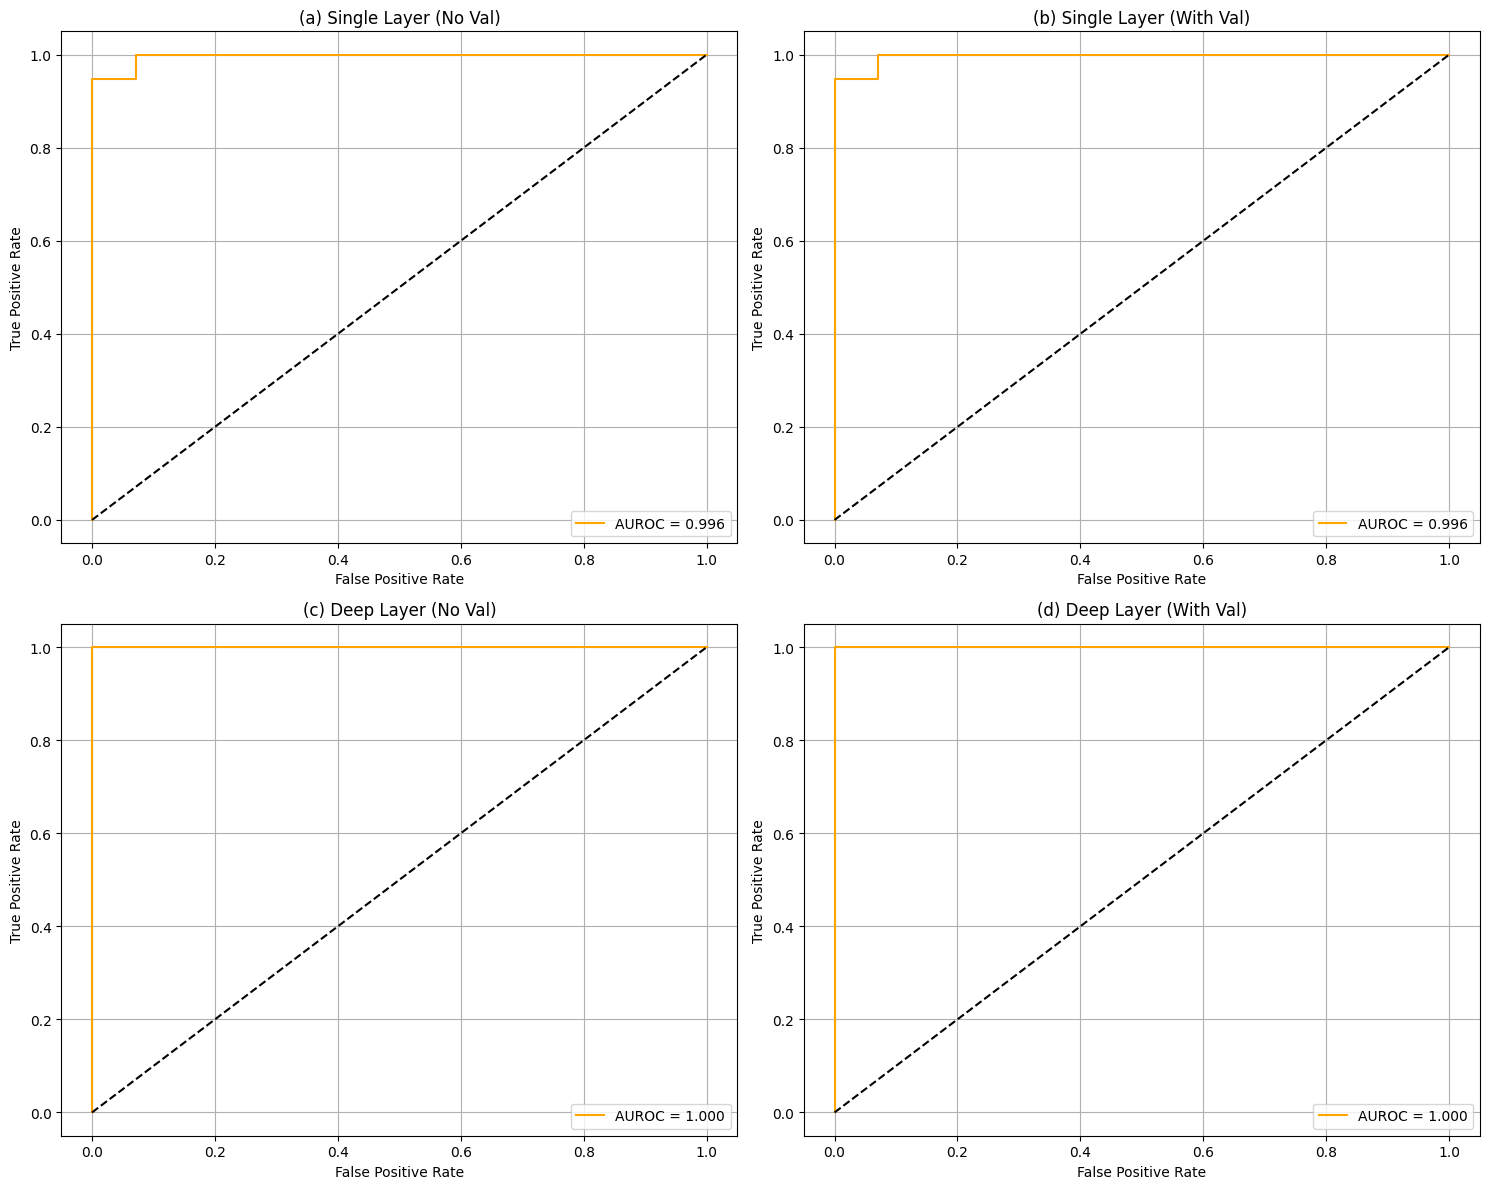

In [18]:
def get_predictions(X, params, is_deep=False):
    if is_deep:
        return fwd_prop_deep(X, params)["A3"]
    else:
        return fwd_prop(X, params)["A2"]

def evaluate_model(X, y, params, name, is_deep=False):
    probs = get_predictions(X, params, is_deep)
    preds = (probs > 0.5).astype(int)

    cm = confusion_matrix(y, preds)
    try:
        tn, fp, fn, tp = cm.ravel()
    except ValueError:
        tn, fp, fn, tp = 0, 0, 0, 0
        if len(cm) == 1:
            if y[0] == 0: tn = cm[0,0]
            else: tp = cm[0,0]

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    fpr, tpr, _ = roc_curve(y, probs)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc, sensitivity, specificity, accuracy, cm

models = [
    ("Single Layer (No Val)", params_no_val, False),
    ("Single Layer (With Val)", params_val, False),
    ("Deep Layer (No Val)", params_deep_no_val, True),
    ("Deep Layer (With Val)", params_deep_val, True)
]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

print("\n--- Final Evaluation Metrics ---")

for i, (title, params, is_deep) in enumerate(models):
    fpr, tpr, roc_auc, sens, spec, acc, cm = evaluate_model(X_test, y_test, params, title, is_deep)

    print(f"\n{title}:")
    print(f"  Confusion Matrix:\n{cm}")
    print(f"  Accuracy: {acc:.4f} | Sensitivity: {sens:.4f} | Specificity: {spec:.4f} | AUROC: {roc_auc:.4f}")

    ax = axes[i]
    ax.plot(fpr, tpr, color='orange', label=f'AUROC = {roc_auc:.3f}')
    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_title(f"({chr(97+i)}) {title}")
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    ax.grid(True)

plt.tight_layout()
plt.show()